In [1]:
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.base import TransformerMixin

In [2]:
raw_data = pd.read_csv("train.csv")
raw_data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


Before modeling the content of each passage, we may be able to build a model that draws on the metafeatures of the documents (e.g., length, the part of speech, the sentiment of the document, etc.) For this part of the analysis, I am going to use two NLP packages: Spacy and Textblob. 

Spacy is feature rich and offers a number of important things like part of speech tagging, stopwords detection, and document tokenization. 

Textblob is an earlier package that has fewer dependiences and an easier installation but fewer features. I am using textblob for the sentiment analysis. 

The third package for text analysis is the Natural Language Tool Kit library (NLTK). This comes packaged with Anaconda it's full of features but it's older and can be clunky. 

In [3]:
# this is the core library from spacy 
# you should install it with pip install spacy
# then pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-1.2.0/en_core_web_md-1.2.0.tar.gz
import en_core_web_sm
from textblob import TextBlob
nlp = en_core_web_sm.load()

In [4]:
# This function is pretty ugly but only requires one loop to execute 
def metafeatures(document):
    """Generates the metafeatures of a document
    """
    doc = nlp(document)
    # keeps track of the document length, this can be accomplished in a number of ways 
    length = 0
    len_list = []
    # list to keep track of the actual tokens 
    token_list = []
    avg_length = 0
    # how many long words are there 
    ratio_4_plus = 0
    # how many stopwords are there 
    ratio_stops = 0
    # how many nouns, verbs, adjectives are there
    ratio_nouns = 0
    ratio_verbs = 0
    ratio_adjectives = 0
    # how much of the data is punctuation 
    ratio_punctuation = 0
    # keep track of words that are lower case and words that are title case (e.g., Title Case)
    ratio_lower = 0
    ratio_title = 0
    for token in doc:
        length += 1
        len_list.append(len(token))
        token_list.append(token.text.lower())
        if token.is_stop:
            ratio_stops += 1
        if len(token.text) >= 4:
            ratio_4_plus += 1
        if token.pos_ == "NOUN":
            ratio_nouns +=1
        if token.pos_ == "VERB":
            ratio_verbs += 1
        if token.pos_ == "ADJ":
            ratio_adjectives += 1
        if token.is_punct:
            ratio_punctuation += 1
        if token.is_title:
            ratio_title += 1
        if token.is_lower:
            ratio_lower += 1
    unique_ratio = len(set(token_list)) / length
    out_tuple = (ratio_stops, ratio_4_plus, ratio_nouns,
                 ratio_verbs, ratio_adjectives, ratio_punctuation, ratio_title,
                 ratio_lower)
    avg_length = sum(len_list) / length
    num_characters = len(document)
    num_unique_characters = len(set(document)) 
    # Originally, I was building averages here found that leaving the raw counts were more informative
    averages = [x for x in out_tuple]
    averages.append(avg_length)
    averages.append(unique_ratio)
    averages.append(num_characters)
    averages.append(num_unique_characters)
    averages.append(length)
    # get sentiment using textblob 
    data_blob = TextBlob(document)
    polarity, subjectivity = data_blob.sentiment[0], data_blob.sentiment[1]
    averages.extend([polarity, subjectivity])
    return averages

columns = ["Stopwords", "LongWords", "Nouns", "Verbs", "Adjectives",
          "Punctuation", "TitleCase", "Lowercase", "AvgLength","UniqueRatio", "NumberOfCharacters",
          "NumberUniqueCharacters", "DocumentLength", "Polarity", "Subjectivity"]

In [5]:
metafeatures_data = [metafeatures(x) for x in raw_data["text"]]
metafeatures_df = pd.DataFrame(metafeatures_data, columns=columns)
metafeatures_df["author"] = raw_data["author"]
metafeatures_df.head()

,Stopwords,LongWords,Nouns,Verbs,Adjectives,Punctuation,TitleCase,Lowercase,AvgLength,UniqueRatio,NumberOfCharacters,NumberUniqueCharacters,DocumentLength,Polarity,Subjectivity,author
0,26,22,9,8,4,7,3,38,3.979167,0.791667,231,28,48,0.625000,0.625000,EAP
1,10,8,2,3,1,1,1,13,3.866667,1.000000,71,22,15,-0.500000,0.500000,HPL
2,17,21,11,4,6,5,1,35,4.024390,0.829268,200,26,41,0.107407,0.681481,EAP
3,14,22,7,5,6,4,4,30,4.552632,0.868421,206,30,38,0.500000,0.662500,MWS
4,14,17,6,5,4,4,2,25,4.774194,0.903226,174,27,31,0.200000,0.512500,HPL


Stopwords


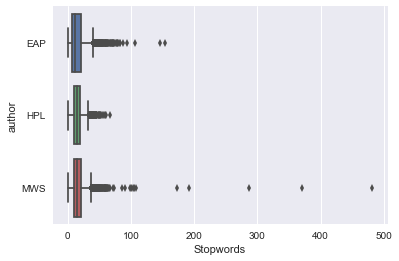

LongWords


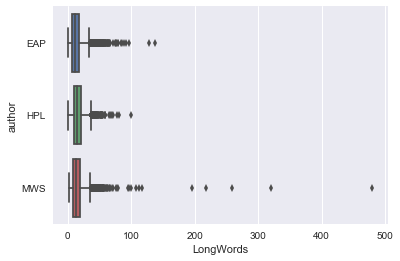

Nouns


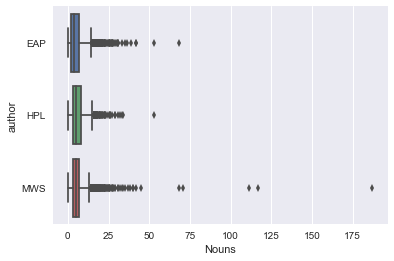

Verbs


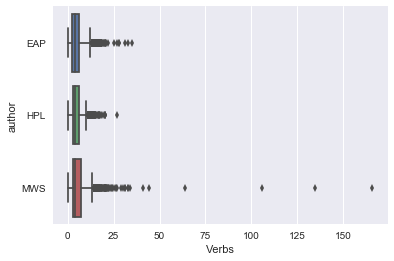

Adjectives


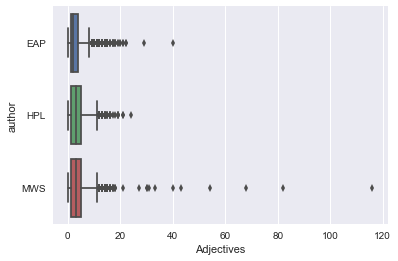

Punctuation


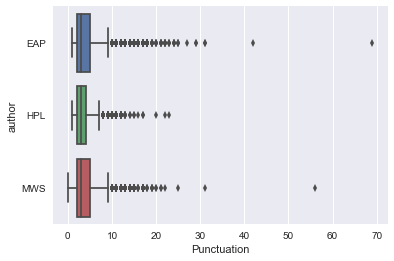

TitleCase


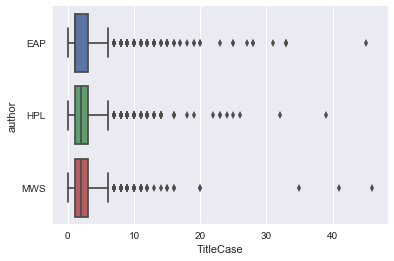

Lowercase


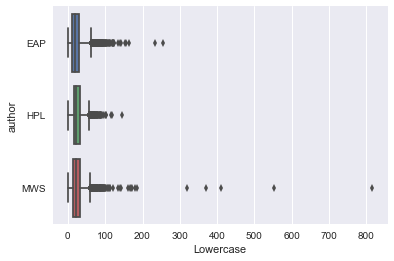

AvgLength


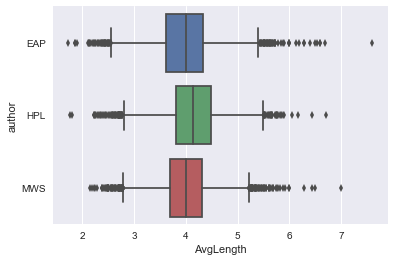

UniqueRatio


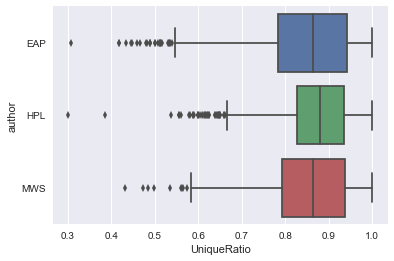

NumberOfCharacters


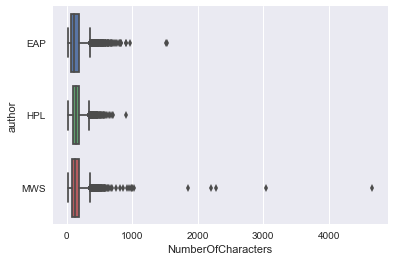

NumberUniqueCharacters


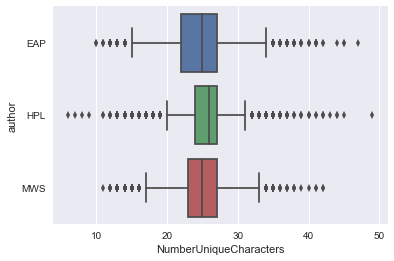

DocumentLength


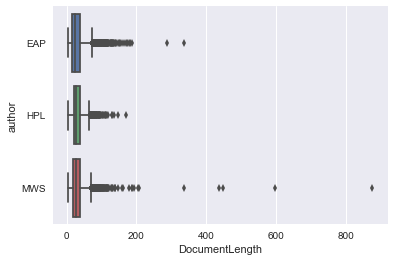

Polarity


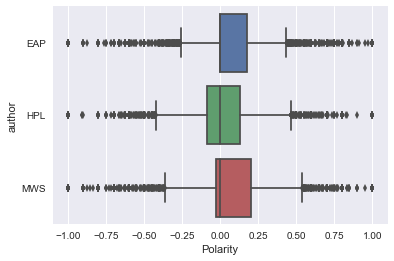

Subjectivity


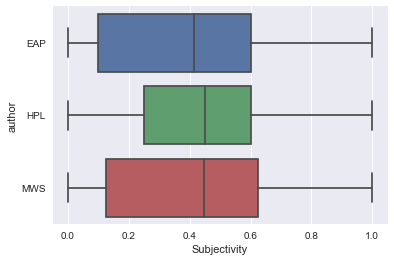

author


In [76]:
%matplotlib inline
from IPython.display import display
import seaborn as sns
# Generate Boxplots by for the quanatative columns with the author
for col in  metafeatures_df:
    print(col)
    if col == "author":
        continue
    subset = [col, "author"]
    img = sns.boxplot(x=col, y="author", data=metafeatures_df[subset])
    fig = img.get_figure()
    display(fig)
    fig.savefig(col)
    fig.clf()


We can try to estimate the importance of the metafeatures we built using a logit model and recurvsive feature elimination. 

In [18]:
lr_clf = LogisticRegression()
rfecv = RFECV(estimator=lr_clf, step=1, cv=StratifiedKFold(10),
              scoring='accuracy')
rfecv.fit(metafeatures_df[keep_columns], raw_data["author"])

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

NameError: name 'StratifiedKFold' is not defined

It looks like the best accuracy came from including all 15 variables. While not particularly interesting, this model achieved ~54% accuracy using just the metafeatures. This may be useful down the road as the metafeatures are agnostic of the words if the training and test sets are derived from different works. 

I am going to try using the text of the words now instead of just the metafeatures. For the first model, I am going to try using just the stopwords (e.g., I, the, a, am) as these are common words that are likely to persist across different works. 

In [6]:
def stopword_features(document):
    document = document.lower()
    doc = nlp(document)
    stopword_string = " ".join([token.text for token in doc if token.is_stop])
    return stopword_string


stopword_strings = [stopword_features(x) for x in raw_data["text"]]
print(stopword_strings[0])

this however me no of the of my as i might make its and to the whence i out without being of the so seemed the


We can use this function now to gather up all of our stopwords. To make this useable for a machine learning algorithm, we'll need to convert it to a matrix. Sklearn has tools that will convert words to a count matrix where each column is a word and the number of times it occurs in the document are the values. 

We'll also make use of the Pipeline class from Sklearn which makes it easy to roll preprocessing steps into one work stream. 

In [ ]:
nb_estimators = [("count_vec", CountVectorizer()), 
              ("NB", MultinomialNB())]
nb_model = Pipeline(nb_estimators)
nb_clf = Pipeline(nb_estimators)
scores = cross_val_score(nb_clf, stopword_strings, raw_data["author"], 
                                              cv=5, 
                                              scoring='accuracy')
print("Accuracy:{0}".format(scores.mean()))

When I ran this, it an accuracy of ~ 61%. This was better than our metafeatures model but still not very good. We'll probably get the best accuracy from the actual words that the authors use (e.g., "Raven" or "Cthulhu") are probably good indicaters of Poe or Lovecraft. 

I am going to try lemmatizing the document to get normalize the text some.

In [7]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def wordnet_get(tagged_tokens):
    """Helper function for normalizing wordnet labels
    """
    out_tokens = []
    for token in tagged_tokens:
        if token[1].startswith("J"):
            out_token = (token[0], wordnet.ADJ)
        elif token[1].startswith("V"):
            out_token = (token[0], wordnet.VERB)
        elif token[1].startswith("R"):
            out_token = (token[0], wordnet.ADV)
        else:
            out_token = (token[0], wordnet.NOUN)
        out_tokens.append(out_token)
    return out_tokens

def clean_document(string, lemmatizer=lemmatizer):
    """Cleans the text by tokenizing, performing POS tagging, and lemmatizing it 
    """
    tokens = nltk.word_tokenize(string)
    pos_tagged = wordnet_get(nltk.pos_tag(tokens))
    lemmas = [lemmatizer.lemmatize(token[0], pos=token[1]).lower() for token in pos_tagged]
    return " ".join(lemmas)

example_doc = """I, me and my are stopwords and will be removed. So will this comma,. 100 is a number. 
                Also, the lemma of better is good"""
clean_document(example_doc)

'i , me and my be stopwords and will be remove . so will this comma , . 100 be a number . also , the lemma of good be good'

In [8]:
min_clean = [clean_document(x) for x in raw_data["text"]]

In [102]:
# We can use grid search here to try to find the best parameters
nb_params = { 
          "count_vec__ngram_range": [(1, 1), (1, 2)], 
          "count_vec__max_df": [1.0, .5]} 

nb_estimators = [("count_vec", CountVectorizer()), 
              ("NB", MultinomialNB())]
nb_model = Pipeline(nb_estimators)
nb_grid = GridSearchCV(estimator=nb_model, param_grid = nb_params)
nb_grid.fit(min_clean, raw_data["author"]) 
print(nb_grid.best_params_)

{'count_vec__max_df': 0.5, 'count_vec__ngram_range': (1, 2)}


In [69]:
token_estimaters = [("count_vectorizer", CountVectorizer(max_df=.5, ngram_range=(1, 2))), 
                  ("NB", MultinomialNB())]
                                                         

content_nb = Pipeline(token_estimaters)
content_scores = cross_val_score(content_nb, min_clean, raw_data["author"], 
                                              cv=5, 
                                              scoring='accuracy')
print("Accuracy:{0}".format(content_scores.mean()))

Accuracy:0.8432501823086866


In addition to the words, we may be able to get some extra signal out of the individual characters. For example, it's possible that Poe uses more semicolons (;) than HPL. We can use the same tools for the character analyzer as the word tokens. 

In [20]:
character_vectorizer = CountVectorizer(analyzer="char")
character_estimators = [("character", character_vectorizer),
                       ("NB", MultinomialNB())]
character_nb = Pipeline(character_estimators)
character_scores = cross_val_score(character_nb, raw_data["text"], raw_data["author"], 
                                              cv=5, 
                                              scoring="accuracy")
print("Accuracy:{0}".format(character_scores.mean()))

Accuracy:0.5496711790512643


The final thing I want to try is to use the Part-of-Speech tags. This may uncover additional patterns that are agnostic to the actual words used by the authors.

In [9]:
def pos_cleaner(document):
    """Generates the part of speech tags for the document
    """
    doc = nlp(document)
    pos_tokens = " ".join([token.tag_ for token in doc])
    return pos_tokens
    
pos_strings = [pos_cleaner(x) for x in raw_data["text"]]


In [87]:
pos_params = { 
          "count_vec__ngram_range": [(2, 4), (2, 5), (4, 4)], 
          "count_vec__min_df": [1, 4]} 

pos_estimators = [("count_vec", CountVectorizer()), 
              ("NB", MultinomialNB())]
pos_model = Pipeline(pos_estimators)
pos_grid = GridSearchCV(estimator=pos_model, param_grid = pos_params)
pos_grid.fit(pos_strings, raw_data["author"]) 
print(pos_grid.best_params_)

{'count_vec__min_df': 1, 'count_vec__ngram_range': (2, 5)}


In [88]:
pos_vectorizer = CountVectorizer(ngram_range=(2, 5), min_df=1)
pos_estimators = [("character", pos_vectorizer),
                       ("NB", MultinomialNB())]
pos_nb = Pipeline(pos_estimators)
pos_scores = cross_val_score(pos_nb, pos_strings, raw_data["author"], 
                                              cv=5, 
                                              scoring="accuracy")
print("Accuracy:{0}".format(pos_scores.mean()))

Accuracy:0.5877733162700229


Including the actual words seems to make the best model. Still, we can probably squeeze more accuracy out of the individual models by stacking them together. 

We have five models now that give five different looks at our data. The metafeatures, the stopwords, the actual content with the most salient tokens, the part of speech tags, and the characters. I am going to add a sixth classifier with no cleaning to the final ensemble model.  

To create a stacking classifier, I am going to use the mlextend library. We also need to write some boilerplate code to combine everything. 

In [6]:
from sklearn.preprocessing import FunctionTransformer

def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

In [118]:
# metafeatures stopwords, pos, simple clean, content
from sklearn.model_selection import KFold
from sklearn import metrics
import numpy as np

train_X = raw_data["text"]
train_y = raw_data["author"]

# read in test data 
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_id = test_df["id"]

In [39]:
# create a vector for just the characters 
char_vectorizer = CountVectorizer(analyzer="char").fit(train_df["text"])
train_vector_char = char_vectorizer.transform(train_df["text"])
test_vector_char = char_vectorizer.transform(test_df["text"])

# create a vector for just the stopwords 
stop_vectorizer = CountVectorizer(preprocessor=stopword_features).fit(train_df["text"])
train_vector_stop = stop_vectorizer.transform(train_df["text"])
test_vector_stop = stop_vectorizer.transform(test_df["text"])

# this fist vector is for the simple vectorizer 
simple_vectorizer = CountVectorizer(lowercase=True).fit(train_df["text"])
train_vector_simple = simple_vectorizer.transform(train_df["text"])
test_vector_simple =  simple_vectorizer.transform(test_df["text"])

# create a vector for the part of speech tagger 
pos_vectorizer = CountVectorizer(preprocessor=pos_cleaner, ngram_range=(2, 3)).fit(train_df["text"])
train_vector_pos = pos_vectorizer.transform(train_df["text"])
test_vector_pos = pos_vectorizer.transform(test_df["text"])




In [70]:
# create a vectorizer for the lemmatized strings 
lemma_vectorizer = CountVectorizer(preprocessor=clean_document, ngram_range=(1, 2), max_df=.5).fit(train_df["text"])
train_vector_lemma = lemma_vectorizer.transform(train_df["text"])
test_vector_lemma =  lemma_vectorizer.transform(test_df["text"])

In [98]:
# create a tfidf matrix with ngram features, this will capture frequent phrases
ngram_vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(2, 6), min_df=5).fit(train_df["text"])
train_vector_ngram = ngram_vectorizer.transform(train_df["text"])
test_vector_ngram =  ngram_vectorizer.transform(test_df["text"])

In [47]:
train_meta = [metafeatures(x) for x in train_df["text"]]
test_meta =  [metafeatures(x) for x in test_df["text"]]

In [61]:
train_vector_meta = pd.DataFrame(train_meta, columns = columns, index=train_df.index)
test_vector_meta = pd.DataFrame(test_meta, columns = columns, index=test_df.index)

In [99]:
print(test_vector_ngram.shape, train_vector_ngram.shape)
print(test_vector_lemma.shape, train_vector_lemma.shape)
print(test_vector_meta.shape, train_vector_meta.shape)
print(test_vector_char.shape, train_vector_char.shape)
print(test_vector_simple.shape, train_vector_simple.shape)
print(test_vector_pos.shape, train_vector_pos.shape)
print(test_vector_stop.shape, train_vector_stop.shape)

(8392, 17025) (19579, 17025)
(8392, 222660) (19579, 222660)
(8392, 15) (19579, 15)
(8392, 58) (19579, 58)
(8392, 25068) (19579, 25068)
(8392, 10401) (19579, 10401)
(8392, 297) (19579, 297)


In [119]:
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
def run_nb(train_X, train_y, test_X, test_y, test_X2):
    model = MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

def run_lr(train_X, train_y, test_X, test_y, test_X2):
    model = LogisticRegression()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

def build_predictions(test_predictions, training_predictions, dev_index, val_index, labels, training_features, 
                      test_features, model_fun):
    """Iteratively collects the predictions from the kfolds then appends them a dataframe
    """
    dev_features, val_features = training_features[dev_index], training_features[val_index]
    dev_labels, val_labels = labels[dev_index], labels[val_index]
    prediction_validation_labels, prediction_test_labels, model = model_fun(dev_features, dev_labels, val_features,
                                                                            val_labels, test_features)
    test_predictions = test_predictions + prediction_test_labels
    training_predictions[val_index,:] = prediction_validation_labels
    return training_predictions, test_predictions

# create the vector for the simple cleaner prediction 
simple_test_predictions = 0
simple_pred_train = np.zeros([train_df.shape[0], 3])
# create a vector for the part of speech cleaner
pos_test_predictions = 0
pos_pred_train = np.zeros([train_df.shape[0], 3])
# create a vector for the stopwords 
stop_test_predictions = 0
stop_pred_train = np.zeros([train_df.shape[0], 3])
# create a vector for the characters 
char_test_predictions = 0
char_pred_train = np.zeros([train_df.shape[0], 3])
# create a vector for the metafeatures 
lr_test_predictions = 0
lr_pred_train = np.zeros([train_df.shape[0], 3])
# create a vector for the lemmatized features 
lemma_test_predictions = 0
lemma_pred_train = np.zeros([train_df.shape[0], 3])
# create a vector for the ngram phrases 
ngram_test_predictions = 0 
ngram_pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    simple_training_predictions, simple_test_predictions = build_predictions(simple_test_predictions, simple_pred_train,
                                                              dev_index, val_index, train_y, train_vector_simple, 
                                                              test_vector_simple, run_nb)
    
    pos_training_predictions, pos_test_predictions = build_predictions(pos_test_predictions, pos_pred_train,
                                                              dev_index, val_index, train_y, train_vector_pos, 
                                                              test_vector_pos, run_nb)
    stop_training_predictions, stop_test_predictions = build_predictions(stop_test_predictions, stop_pred_train,
                                                              dev_index, val_index, train_y, train_vector_stop, 
                                                              test_vector_stop, run_nb)
    char_training_predictions, char_test_predictions = build_predictions(char_test_predictions, char_pred_train,
                                                              dev_index, val_index, train_y, train_vector_char, 
                                                              test_vector_char, run_nb)
   
    lr_training_predictions, lr_test_predictions = build_predictions(lr_test_predictions, lr_pred_train,
                                                              dev_index, val_index, train_y, train_vector_simple , 
                                                              test_vector_simple, run_lr)
    
    lemma_training_predictions, lemma_test_predictions = build_predictions(lemma_test_predictions, lemma_pred_train,
                                                              dev_index, val_index, train_y, train_vector_lemma , 
                                                              test_vector_lemma, run_nb)
    
    ngram_training_predictions, ngram_test_predictions = build_predictions(ngram_test_predictions, ngram_pred_train,
                                                              dev_index, val_index, train_y, train_vector_ngram , 
                                                              test_vector_ngram, run_lr)
    
    


    
    #### Add all the predictions to a data frame to use as metafeatures ####
def unpack_probabilities(train_df, train_predictions, test_df, test_predictions, column_label):
    """Appends the predicted probabilites to the dataframes
    """
    eap_label = "{0}_eap".format(column_label)
    hpl_label = "{0}_hpl".format(column_label)
    mws_label = "{0}_mws".format(column_label)
    train_df[eap_label], test_df[eap_label] = train_predictions[:, 0], test_predictions[:, 0]
    train_df[hpl_label], test_df[hpl_label] = train_predictions[:, 1], test_predictions[:, 1]
    train_df[mws_label], test_df[mws_label] = train_predictions[:, 2], test_predictions[:, 2]
    return train_df, test_df
    
    
train_df, test_df = unpack_probabilities(train_df, simple_training_predictions, test_df, simple_test_predictions, "nb_simple")
train_df, test_df = unpack_probabilities(train_df, pos_training_predictions, test_df, pos_test_predictions, "nb_pos")
train_df, test_df = unpack_probabilities(train_df, stop_training_predictions, test_df, stop_test_predictions, "nb_stop")
train_df, test_df = unpack_probabilities(train_df, char_training_predictions, test_df, char_test_predictions, "nb_char")
train_df, test_df = unpack_probabilities(train_df, lr_training_predictions, test_df, lr_test_predictions, "lr_simple")
train_df, test_df = unpack_probabilities(train_df, lemma_training_predictions, test_df, lemma_test_predictions, "nb_lemma")
# train_df, test_df = unpack_probabilities(train_df, ngram_training_predictions, test_df, ngram_test_predictions, "lr_ngram")

In [120]:
train_df = pd.concat([train_df, train_vector_meta], axis=1)
test_df = pd.concat([test_df, test_vector_meta], axis=1)
train_df.head()

,id,text,author,nb_simple_eap,nb_simple_hpl,nb_simple_mws,nb_pos_eap,nb_pos_hpl,nb_pos_mws,nb_stop_eap,...,Punctuation,TitleCase,Lowercase,AvgLength,UniqueRatio,NumberOfCharacters,NumberUniqueCharacters,DocumentLength,Polarity,Subjectivity
0,id26305,"This process, however, afforded me no means of...",EAP,9.999994e-01,3.950403e-07,2.149032e-07,9.664979e-01,0.000047,0.033455,0.901087,...,7,3,38,3.979167,0.791667,231,28,48,0.625000,0.625000
1,id17569,It never once occurred to me that the fumbling...,HPL,8.882647e-01,7.835361e-02,3.338169e-02,5.937842e-01,0.006138,0.400077,0.400400,...,1,1,13,3.866667,1.000000,71,22,15,-0.500000,0.500000
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,9.780036e-01,2.199053e-02,5.887788e-06,9.149409e-01,0.084884,0.000175,0.142927,...,5,1,35,4.024390,0.829268,200,26,41,0.107407,0.681481
3,id27763,How lovely is spring As we looked from Windsor...,MWS,1.568978e-09,1.081852e-09,1.000000e+00,7.498435e-08,0.999996,0.000004,0.352653,...,4,4,30,4.552632,0.868421,206,30,38,0.500000,0.662500
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,6.310465e-01,3.661372e-01,2.816277e-03,9.991643e-01,0.000003,0.000832,0.180823,...,4,2,25,4.774194,0.903226,174,27,31,0.200000,0.512500


In [121]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier()

def run_xgb(train_X, train_y, test_X, test_y, output_test_X):
    model = xgb.XGBClassifier()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    output_predictions = model.predict_proba(output_test_X)
    return pred_test_y, output_predictions, model



In [122]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, final_model = run_xgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.head()

cv scores :  [0.32117715142619135]


,EAP,HPL,MWS
0,0.131763,0.012227,0.856009
1,0.964202,0.014021,0.021777
2,0.003489,0.975387,0.021124
3,0.772583,0.222674,0.004744
4,0.782727,0.117969,0.099304


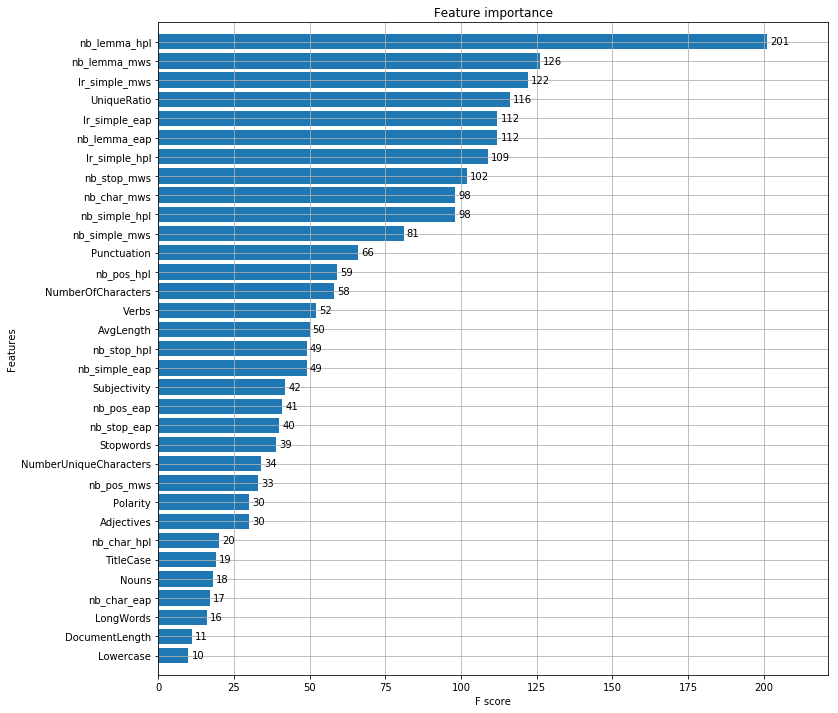

In [123]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(final_model, height=0.8, ax=ax)
plt.show()

In [117]:
out_df["id"] = test_id 
out_df.to_csv("SubmissionCSV2.csv", index=False)

Below, I have another approach to stacking models. This method is less verbose but will take longer durning the feature transformations because each transformation function is called again and again during the cross-validation. 

In [105]:
from mlxtend.classifier import StackingClassifier
vectorizer = CountVectorizer(lowercase=True)


pos_pipeline = [("pos_clean", pipelinize(pos_cleaner)),
    ("pos_vector", CountVectorizer(ngram_range=(2, 5), min_df=1)),
    ("NB", MultinomialNB())]

character_pipeline = [("character", CountVectorizer(analyzer="char")),
                       ("NB", MultinomialNB())]

simple_pipeline = [("vectorizer", CountVectorizer()),
                  ("simple_nb", MultinomialNB())]

content_pipeline = [("simple_clean", pipelinize(clean_document)),
                   ("count_vectorizer", CountVectorizer(max_df=.5, ngram_range=(1, 2))), 
                   ("NB", MultinomialNB())]

meta_pipeline = [("meta_featuers", pipelinize(metafeatures)),
                 ("LR", LogisticRegression())]

stopword_pipeline = [("stopword_clean", pipelinize(stopword_features)),
                    ("count_vectorizer", CountVectorizer()),
                    ("NB", MultinomialNB())]


# pos_clf = Pipeline(pos_pipeline)
# character_clf = Pipeline(character_pipeline)
# simple_clf = Pipeline(simple_pipeline)
# content_clf = Pipeline(content_pipeline)
# meta_clf = Pipeline(meta_pipeline)
# stopword_clf = Pipeline(stopword_pipeline)

In [15]:
import time
def clean_documents(document_list, lemmatizer=lemmatizer):
    out_list = []
    for document in document_list:
        tokens = nltk.word_tokenize(document)
        pos_tagged = wordnet_get(nltk.pos_tag(tokens))
        lemmas = [lemmatizer.lemmatize(token[0], pos=token[1]).lower() for token in pos_tagged]
        out_string = " ".join(lemmas)
        out_list.append(out_string)
    return out_list
before_compherension = time.time()
e = clean_documents(raw_data["text"])
after_compherension = time.time()
print(after_compherension - before_compherension)

229.2231137752533


In [108]:
# pos, character, simple, content, meta, stopword
# drop character and meta classifiers as they haven't seem to improve predictions much
from mlxtend.classifier import EnsembleVoteClassifier
weights = [1, 2, 2]
pos_clf = Pipeline(pos_pipeline)
# character_clf = Pipeline(character_pipeline)
simple_clf = Pipeline(simple_pipeline)
content_clf = Pipeline(content_pipeline)
# meta_clf = Pipeline(meta_pipeline)
# stopword_clf = Pipeline(stopword_pipeline)
clf_batch = [pos_clf, simple_clf, content_clf]

eclf = EnsembleVoteClassifier(clfs=clf_batch, weights=weights, voting="soft")
ensemble_scores = cross_val_score(eclf, raw_data["text"], raw_data["author"], 
                                              cv=3, 
                                              scoring="accuracy")
print(ensemble_scores.mean())

KeyboardInterrupt: 